# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
from DQNAgent import Agent, HyperParameter
from ExperienceReplayBuffer import *
from QNetwork import QNetwork

batch_size = 64
buffer_size = 10000
device = "cuda:0"
seed = 12345

params = HyperParameter(batch_size=batch_size)
print(params)
memory = ExperienceReplayBuffer(action_size=action_size, buffer_size=buffer_size, 
                                device=device, seed=seed)
# memory = PrioritizedReplayBuffer(action_size=action_size, buffer_size=buffer_size, alpha=0.5,
#                                  device=device, seed=seed)
model = QNetwork(state_size, action_size, seed)
agent = Agent(state_size, action_size, device, memory, model, hyperparameter = params)


HyperParameter(learning_rate=0.0005, update_every=4, batch_size=64, gamma=0.99, tau=0.001)


In [6]:
import torch

def dqn(brain_name, n_episodes=5000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset(train_mode=True)[brain_name].vector_observations[0]
        score = 0
        while True:
            action = agent.act(state, eps)       # select an action
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state,action,reward,next_state,done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # s|ave most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            break
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), 'model.pth')
    return scores

scores = dqn(brain_name, n_episodes=2000)


Episode 1	Average Score: 0.00

Episode 2	Average Score: 1.00

Episode 3	Average Score: 0.33

Episode 4	Average Score: -0.25

Episode 5	Average Score: -0.40

Episode 6	Average Score: -0.33

Episode 7	Average Score: -0.29

Episode 8	Average Score: -0.25

Episode 9	Average Score: -0.11

Episode 10	Average Score: -0.10

Episode 11	Average Score: -0.09

Episode 12	Average Score: 0.08

Episode 13	Average Score: 0.15

Episode 14	Average Score: 0.21

Episode 15	Average Score: 0.20

Episode 16	Average Score: 0.19

Episode 17	Average Score: 0.18

Episode 18	Average Score: 0.22

Episode 19	Average Score: 0.21

Episode 20	Average Score: 0.20

Episode 21	Average Score: 0.19

Episode 22	Average Score: 0.23

Episode 23	Average Score: 0.26

Episode 24	Average Score: 0.29

Episode 25	Average Score: 0.24

Episode 26	Average Score: 0.19

Episode 27	Average Score: 0.19

Episode 28	Average Score: 0.21

Episode 29	Average Score: 0.21

Episode 30	Average Score: 0.20

Episode 31	Average Score: 0.19

Episode 32	Average Score: 0.19

Episode 33	Average Score: 0.09

Episode 34	Average Score: 0.06

Episode 35	Average Score: 0.03

Episode 36	Average Score: 0.06

Episode 37	Average Score: 0.08

Episode 38	Average Score: 0.08

Episode 39	Average Score: 0.10

Episode 40	Average Score: 0.07

Episode 41	Average Score: 0.05

Episode 42	Average Score: 0.12

Episode 43	Average Score: 0.12

Episode 44	Average Score: 0.11

Episode 45	Average Score: 0.07

Episode 46	Average Score: 0.07

Episode 47	Average Score: 0.13

Episode 48	Average Score: 0.12

Episode 49	Average Score: 0.14

Episode 50	Average Score: 0.12

Episode 51	Average Score: 0.16

Episode 52	Average Score: 0.15

Episode 53	Average Score: 0.11

Episode 54	Average Score: 0.15

Episode 55	Average Score: 0.16

Episode 56	Average Score: 0.16

Episode 57	Average Score: 0.16

Episode 58	Average Score: 0.16

Episode 59	Average Score: 0.15

Episode 60	Average Score: 0.13

Episode 61	Average Score: 0.11

Episode 62	Average Score: 0.13

Episode 63	Average Score: 0.13

Episode 64	Average Score: 0.16

Episode 65	Average Score: 0.17

Episode 66	Average Score: 0.20

Episode 67	Average Score: 0.22

Episode 68	Average Score: 0.22

Episode 69	Average Score: 0.22

Episode 70	Average Score: 0.23

Episode 71	Average Score: 0.23

Episode 72	Average Score: 0.24

Episode 73	Average Score: 0.26

Episode 74	Average Score: 0.24

Episode 75	Average Score: 0.23

Episode 76	Average Score: 0.29

Episode 77	Average Score: 0.27

Episode 78	Average Score: 0.27

Episode 79	Average Score: 0.32

Episode 80	Average Score: 0.31

Episode 81	Average Score: 0.33

Episode 82	Average Score: 0.34

Episode 83	Average Score: 0.33

Episode 84	Average Score: 0.37

Episode 85	Average Score: 0.38

Episode 86	Average Score: 0.41

Episode 87	Average Score: 0.40

Episode 88	Average Score: 0.40

Episode 89	Average Score: 0.40

Episode 90	Average Score: 0.40

Episode 91	Average Score: 0.40

Episode 92	Average Score: 0.40

Episode 93	Average Score: 0.42

Episode 94	Average Score: 0.38

Episode 95	Average Score: 0.43

Episode 96	Average Score: 0.46

Episode 97	Average Score: 0.47

Episode 98	Average Score: 0.49

Episode 99	Average Score: 0.53

Episode 100	Average Score: 0.52


Episode 101	Average Score: 0.53

Episode 102	Average Score: 0.51

Episode 103	Average Score: 0.53

Episode 104	Average Score: 0.55

Episode 105	Average Score: 0.57

Episode 106	Average Score: 0.58

Episode 107	Average Score: 0.59

Episode 108	Average Score: 0.58

Episode 109	Average Score: 0.61

Episode 110	Average Score: 0.63

Episode 111	Average Score: 0.64

Episode 112	Average Score: 0.65

Episode 113	Average Score: 0.66

Episode 114	Average Score: 0.70

Episode 115	Average Score: 0.75

Episode 116	Average Score: 0.78

Episode 117	Average Score: 0.77

Episode 118	Average Score: 0.79

Episode 119	Average Score: 0.81

Episode 120	Average Score: 0.81

Episode 121	Average Score: 0.83

Episode 122	Average Score: 0.85

Episode 123	Average Score: 0.87

Episode 124	Average Score: 0.90

Episode 125	Average Score: 0.96

Episode 126	Average Score: 1.01

Episode 127	Average Score: 1.04

Episode 128	Average Score: 1.07

Episode 129	Average Score: 1.07

Episode 130	Average Score: 1.11

Episode 131	Average Score: 1.14

Episode 132	Average Score: 1.15

Episode 133	Average Score: 1.22

Episode 134	Average Score: 1.30

Episode 135	Average Score: 1.34

Episode 136	Average Score: 1.35

Episode 137	Average Score: 1.37

Episode 138	Average Score: 1.39

Episode 139	Average Score: 1.45

Episode 140	Average Score: 1.49

Episode 141	Average Score: 1.54

Episode 142	Average Score: 1.51

Episode 143	Average Score: 1.51

Episode 144	Average Score: 1.53

Episode 145	Average Score: 1.58

Episode 146	Average Score: 1.63

Episode 147	Average Score: 1.67

Episode 148	Average Score: 1.71

Episode 149	Average Score: 1.73

Episode 150	Average Score: 1.77

Episode 151	Average Score: 1.82

Episode 152	Average Score: 1.85

Episode 153	Average Score: 1.90

Episode 154	Average Score: 1.92

Episode 155	Average Score: 1.98

Episode 156	Average Score: 2.02

Episode 157	Average Score: 2.03

Episode 158	Average Score: 2.08

Episode 159	Average Score: 2.11

Episode 160	Average Score: 2.20

Episode 161	Average Score: 2.26

Episode 162	Average Score: 2.34

Episode 163	Average Score: 2.39

Episode 164	Average Score: 2.44

Episode 165	Average Score: 2.51

Episode 166	Average Score: 2.52

Episode 167	Average Score: 2.57

Episode 168	Average Score: 2.57

Episode 169	Average Score: 2.61

Episode 170	Average Score: 2.66

Episode 171	Average Score: 2.71

Episode 172	Average Score: 2.74

Episode 173	Average Score: 2.79

Episode 174	Average Score: 2.86

Episode 175	Average Score: 2.93

Episode 176	Average Score: 2.92

Episode 177	Average Score: 3.02

Episode 178	Average Score: 3.07

Episode 179	Average Score: 3.10

Episode 180	Average Score: 3.17

Episode 181	Average Score: 3.19

Episode 182	Average Score: 3.23

Episode 183	Average Score: 3.31

Episode 184	Average Score: 3.29

Episode 185	Average Score: 3.32

Episode 186	Average Score: 3.31

Episode 187	Average Score: 3.38

Episode 188	Average Score: 3.45

Episode 189	Average Score: 3.51

Episode 190	Average Score: 3.61

Episode 191	Average Score: 3.68

Episode 192	Average Score: 3.79

Episode 193	Average Score: 3.83

Episode 194	Average Score: 3.95

Episode 195	Average Score: 3.92

Episode 196	Average Score: 3.96

Episode 197	Average Score: 4.01

Episode 198	Average Score: 4.05

Episode 199	Average Score: 4.10

Episode 200	Average Score: 4.14


Episode 201	Average Score: 4.20

Episode 202	Average Score: 4.21

Episode 203	Average Score: 4.25

Episode 204	Average Score: 4.29

Episode 205	Average Score: 4.31

Episode 206	Average Score: 4.31

Episode 207	Average Score: 4.37

Episode 208	Average Score: 4.41

Episode 209	Average Score: 4.46

Episode 210	Average Score: 4.51

Episode 211	Average Score: 4.50

Episode 212	Average Score: 4.53

Episode 213	Average Score: 4.59

Episode 214	Average Score: 4.60

Episode 215	Average Score: 4.59

Episode 216	Average Score: 4.61

Episode 217	Average Score: 4.66

Episode 218	Average Score: 4.65

Episode 219	Average Score: 4.69

Episode 220	Average Score: 4.73

Episode 221	Average Score: 4.76

Episode 222	Average Score: 4.79

Episode 223	Average Score: 4.77

Episode 224	Average Score: 4.77

Episode 225	Average Score: 4.82

Episode 226	Average Score: 4.90

Episode 227	Average Score: 4.92

Episode 228	Average Score: 4.89

Episode 229	Average Score: 4.95

Episode 230	Average Score: 4.99

Episode 231	Average Score: 5.02

Episode 232	Average Score: 5.10

Episode 233	Average Score: 5.15

Episode 234	Average Score: 5.17

Episode 235	Average Score: 5.23

Episode 236	Average Score: 5.27

Episode 237	Average Score: 5.32

Episode 238	Average Score: 5.40

Episode 239	Average Score: 5.37

Episode 240	Average Score: 5.38

Episode 241	Average Score: 5.40

Episode 242	Average Score: 5.46

Episode 243	Average Score: 5.50

Episode 244	Average Score: 5.50

Episode 245	Average Score: 5.54

Episode 246	Average Score: 5.54

Episode 247	Average Score: 5.55

Episode 248	Average Score: 5.62

Episode 249	Average Score: 5.69

Episode 250	Average Score: 5.74

Episode 251	Average Score: 5.76

Episode 252	Average Score: 5.80

Episode 253	Average Score: 5.84

Episode 254	Average Score: 5.81

Episode 255	Average Score: 5.77

Episode 256	Average Score: 5.78

Episode 257	Average Score: 5.81

Episode 258	Average Score: 5.83

Episode 259	Average Score: 5.89

Episode 260	Average Score: 5.90

Episode 261	Average Score: 5.86

Episode 262	Average Score: 5.85

Episode 263	Average Score: 5.85

Episode 264	Average Score: 5.83

Episode 265	Average Score: 5.82

Episode 266	Average Score: 5.87

Episode 267	Average Score: 5.82

Episode 268	Average Score: 5.89

Episode 269	Average Score: 5.86

Episode 270	Average Score: 5.87

Episode 271	Average Score: 5.84

Episode 272	Average Score: 5.85

Episode 273	Average Score: 5.89

Episode 274	Average Score: 5.90

Episode 275	Average Score: 5.90

Episode 276	Average Score: 5.93

Episode 277	Average Score: 5.94

Episode 278	Average Score: 5.91

Episode 279	Average Score: 5.85

Episode 280	Average Score: 5.80

Episode 281	Average Score: 5.81

Episode 282	Average Score: 5.78

Episode 283	Average Score: 5.76

Episode 284	Average Score: 5.83

Episode 285	Average Score: 5.89

Episode 286	Average Score: 5.91

Episode 287	Average Score: 5.89

Episode 288	Average Score: 5.91

Episode 289	Average Score: 5.94

Episode 290	Average Score: 5.94

Episode 291	Average Score: 5.97

Episode 292	Average Score: 5.96

Episode 293	Average Score: 6.03

Episode 294	Average Score: 5.96

Episode 295	Average Score: 5.98

Episode 296	Average Score: 5.97

Episode 297	Average Score: 5.99

Episode 298	Average Score: 5.92

Episode 299	Average Score: 5.91

Episode 300	Average Score: 5.90


Episode 301	Average Score: 5.87

Episode 302	Average Score: 5.90

Episode 303	Average Score: 5.90

Episode 304	Average Score: 5.97

Episode 305	Average Score: 6.03

Episode 306	Average Score: 6.14

Episode 307	Average Score: 6.14

Episode 308	Average Score: 6.18

Episode 309	Average Score: 6.14

Episode 310	Average Score: 6.19

Episode 311	Average Score: 6.33

Episode 312	Average Score: 6.34

Episode 313	Average Score: 6.35

Episode 314	Average Score: 6.30

Episode 315	Average Score: 6.37

Episode 316	Average Score: 6.40

Episode 317	Average Score: 6.48

Episode 318	Average Score: 6.51

Episode 319	Average Score: 6.49

Episode 320	Average Score: 6.54

Episode 321	Average Score: 6.58

Episode 322	Average Score: 6.59

Episode 323	Average Score: 6.72

Episode 324	Average Score: 6.76

Episode 325	Average Score: 6.71

Episode 326	Average Score: 6.72

Episode 327	Average Score: 6.72

Episode 328	Average Score: 6.78

Episode 329	Average Score: 6.76

Episode 330	Average Score: 6.81

Episode 331	Average Score: 6.84

Episode 332	Average Score: 6.77

Episode 333	Average Score: 6.76

Episode 334	Average Score: 6.77

Episode 335	Average Score: 6.74

Episode 336	Average Score: 6.71

Episode 337	Average Score: 6.74

Episode 338	Average Score: 6.71

Episode 339	Average Score: 6.73

Episode 340	Average Score: 6.76

Episode 341	Average Score: 6.76

Episode 342	Average Score: 6.80

Episode 343	Average Score: 6.82

Episode 344	Average Score: 6.87

Episode 345	Average Score: 6.90

Episode 346	Average Score: 6.86

Episode 347	Average Score: 6.81

Episode 348	Average Score: 6.77

Episode 349	Average Score: 6.75

Episode 350	Average Score: 6.74

Episode 351	Average Score: 6.73

Episode 352	Average Score: 6.74

Episode 353	Average Score: 6.77

Episode 354	Average Score: 6.81

Episode 355	Average Score: 6.88

Episode 356	Average Score: 6.88

Episode 357	Average Score: 6.91

Episode 358	Average Score: 6.95

Episode 359	Average Score: 6.99

Episode 360	Average Score: 6.97

Episode 361	Average Score: 7.00

Episode 362	Average Score: 7.01

Episode 363	Average Score: 7.06

Episode 364	Average Score: 7.03

Episode 365	Average Score: 7.07

Episode 366	Average Score: 7.07

Episode 367	Average Score: 7.11

Episode 368	Average Score: 7.12

Episode 369	Average Score: 7.18

Episode 370	Average Score: 7.17

Episode 371	Average Score: 7.26

Episode 372	Average Score: 7.32

Episode 373	Average Score: 7.34

Episode 374	Average Score: 7.35

Episode 375	Average Score: 7.40

Episode 376	Average Score: 7.44

Episode 377	Average Score: 7.39

Episode 378	Average Score: 7.45

Episode 379	Average Score: 7.54

Episode 380	Average Score: 7.63

Episode 381	Average Score: 7.69

Episode 382	Average Score: 7.75

Episode 383	Average Score: 7.78

Episode 384	Average Score: 7.77

Episode 385	Average Score: 7.79

Episode 386	Average Score: 7.84

Episode 387	Average Score: 7.92

Episode 388	Average Score: 7.88

Episode 389	Average Score: 7.84

Episode 390	Average Score: 7.82

Episode 391	Average Score: 7.83

Episode 392	Average Score: 7.80

Episode 393	Average Score: 7.77

Episode 394	Average Score: 7.82

Episode 395	Average Score: 7.90

Episode 396	Average Score: 7.98

Episode 397	Average Score: 7.94

Episode 398	Average Score: 8.03

Episode 399	Average Score: 8.05

Episode 400	Average Score: 8.14


Episode 401	Average Score: 8.21

Episode 402	Average Score: 8.31

Episode 403	Average Score: 8.36

Episode 404	Average Score: 8.32

Episode 405	Average Score: 8.37

Episode 406	Average Score: 8.38

Episode 407	Average Score: 8.42

Episode 408	Average Score: 8.47

Episode 409	Average Score: 8.51

Episode 410	Average Score: 8.51

Episode 411	Average Score: 8.41

Episode 412	Average Score: 8.51

Episode 413	Average Score: 8.51

Episode 414	Average Score: 8.59

Episode 415	Average Score: 8.58

Episode 416	Average Score: 8.56

Episode 417	Average Score: 8.56

Episode 418	Average Score: 8.63

Episode 419	Average Score: 8.72

Episode 420	Average Score: 8.73

Episode 421	Average Score: 8.74

Episode 422	Average Score: 8.81

Episode 423	Average Score: 8.75

Episode 424	Average Score: 8.77

Episode 425	Average Score: 8.83

Episode 426	Average Score: 8.80

Episode 427	Average Score: 8.87

Episode 428	Average Score: 8.98

Episode 429	Average Score: 9.03

Episode 430	Average Score: 9.01

Episode 431	Average Score: 9.02

Episode 432	Average Score: 9.04

Episode 433	Average Score: 9.07

Episode 434	Average Score: 9.02

Episode 435	Average Score: 9.10

Episode 436	Average Score: 9.20

Episode 437	Average Score: 9.22

Episode 438	Average Score: 9.23

Episode 439	Average Score: 9.27

Episode 440	Average Score: 9.34

Episode 441	Average Score: 9.32

Episode 442	Average Score: 9.40

Episode 443	Average Score: 9.42

Episode 444	Average Score: 9.44

Episode 445	Average Score: 9.40

Episode 446	Average Score: 9.47

Episode 447	Average Score: 9.53

Episode 448	Average Score: 9.56

Episode 449	Average Score: 9.63

Episode 450	Average Score: 9.65

Episode 451	Average Score: 9.68

Episode 452	Average Score: 9.66

Episode 453	Average Score: 9.67

Episode 454	Average Score: 9.79

Episode 455	Average Score: 9.78

Episode 456	Average Score: 9.87

Episode 457	Average Score: 9.89

Episode 458	Average Score: 9.87

Episode 459	Average Score: 9.85

Episode 460	Average Score: 9.89

Episode 461	Average Score: 9.89

Episode 462	Average Score: 9.89

Episode 463	Average Score: 9.84

Episode 464	Average Score: 9.87

Episode 465	Average Score: 9.92

Episode 466	Average Score: 9.94

Episode 467	Average Score: 10.05

Episode 468	Average Score: 10.06

Episode 469	Average Score: 10.12

Episode 470	Average Score: 10.13

Episode 471	Average Score: 10.18

Episode 472	Average Score: 10.08

Episode 473	Average Score: 10.07

Episode 474	Average Score: 10.11

Episode 475	Average Score: 10.09

Episode 476	Average Score: 10.06

Episode 477	Average Score: 10.09

Episode 478	Average Score: 10.12

Episode 479	Average Score: 10.15

Episode 480	Average Score: 10.14

Episode 481	Average Score: 10.13

Episode 482	Average Score: 10.18

Episode 483	Average Score: 10.28

Episode 484	Average Score: 10.35

Episode 485	Average Score: 10.37

Episode 486	Average Score: 10.40

Episode 487	Average Score: 10.30

Episode 488	Average Score: 10.35

Episode 489	Average Score: 10.45

Episode 490	Average Score: 10.48

Episode 491	Average Score: 10.44

Episode 492	Average Score: 10.44

Episode 493	Average Score: 10.49

Episode 494	Average Score: 10.48

Episode 495	Average Score: 10.50

Episode 496	Average Score: 10.45

Episode 497	Average Score: 10.59

Episode 498	Average Score: 10.57

Episode 499	Average Score: 10.60

Episode 500	Average Score: 10.58


Episode 501	Average Score: 10.64

Episode 502	Average Score: 10.54

Episode 503	Average Score: 10.56

Episode 504	Average Score: 10.59

Episode 505	Average Score: 10.58

Episode 506	Average Score: 10.51

Episode 507	Average Score: 10.53

Episode 508	Average Score: 10.58

Episode 509	Average Score: 10.57

Episode 510	Average Score: 10.56

Episode 511	Average Score: 10.65

Episode 512	Average Score: 10.61

Episode 513	Average Score: 10.60

Episode 514	Average Score: 10.69

Episode 515	Average Score: 10.71

Episode 516	Average Score: 10.76

Episode 517	Average Score: 10.73

Episode 518	Average Score: 10.71

Episode 519	Average Score: 10.65

Episode 520	Average Score: 10.69

Episode 521	Average Score: 10.67

Episode 522	Average Score: 10.69

Episode 523	Average Score: 10.70

Episode 524	Average Score: 10.71

Episode 525	Average Score: 10.71

Episode 526	Average Score: 10.73

Episode 527	Average Score: 10.74

Episode 528	Average Score: 10.74

Episode 529	Average Score: 10.73

Episode 530	Average Score: 10.75

Episode 531	Average Score: 10.77

Episode 532	Average Score: 10.83

Episode 533	Average Score: 10.90

Episode 534	Average Score: 10.94

Episode 535	Average Score: 10.90

Episode 536	Average Score: 10.84

Episode 537	Average Score: 10.87

Episode 538	Average Score: 10.80

Episode 539	Average Score: 10.82

Episode 540	Average Score: 10.72

Episode 541	Average Score: 10.75

Episode 542	Average Score: 10.68

Episode 543	Average Score: 10.72

Episode 544	Average Score: 10.73

Episode 545	Average Score: 10.77

Episode 546	Average Score: 10.75

Episode 547	Average Score: 10.76

Episode 548	Average Score: 10.78

Episode 549	Average Score: 10.76

Episode 550	Average Score: 10.81

Episode 551	Average Score: 10.80

Episode 552	Average Score: 10.85

Episode 553	Average Score: 10.85

Episode 554	Average Score: 10.72

Episode 555	Average Score: 10.80

Episode 556	Average Score: 10.78

Episode 557	Average Score: 10.80

Episode 558	Average Score: 10.83

Episode 559	Average Score: 10.90

Episode 560	Average Score: 10.90

Episode 561	Average Score: 10.96

Episode 562	Average Score: 11.01

Episode 563	Average Score: 11.09

Episode 564	Average Score: 11.14

Episode 565	Average Score: 11.08

Episode 566	Average Score: 11.08

Episode 567	Average Score: 10.98

Episode 568	Average Score: 11.01

Episode 569	Average Score: 11.02

Episode 570	Average Score: 11.02

Episode 571	Average Score: 11.00

Episode 572	Average Score: 11.13

Episode 573	Average Score: 11.19

Episode 574	Average Score: 11.16

Episode 575	Average Score: 11.19

Episode 576	Average Score: 11.26

Episode 577	Average Score: 11.30

Episode 578	Average Score: 11.34

Episode 579	Average Score: 11.29

Episode 580	Average Score: 11.32

Episode 581	Average Score: 11.31

Episode 582	Average Score: 11.29

Episode 583	Average Score: 11.30

Episode 584	Average Score: 11.23

Episode 585	Average Score: 11.14

Episode 586	Average Score: 11.13

Episode 587	Average Score: 11.18

Episode 588	Average Score: 11.19

Episode 589	Average Score: 11.15

Episode 590	Average Score: 11.21

Episode 591	Average Score: 11.33

Episode 592	Average Score: 11.38

Episode 593	Average Score: 11.35

Episode 594	Average Score: 11.48

Episode 595	Average Score: 11.46

Episode 596	Average Score: 11.41

Episode 597	Average Score: 11.35

Episode 598	Average Score: 11.42

Episode 599	Average Score: 11.43

Episode 600	Average Score: 11.42


Episode 601	Average Score: 11.45

Episode 602	Average Score: 11.54

Episode 603	Average Score: 11.53

Episode 604	Average Score: 11.50

Episode 605	Average Score: 11.50

Episode 606	Average Score: 11.56

Episode 607	Average Score: 11.47

Episode 608	Average Score: 11.41

Episode 609	Average Score: 11.49

Episode 610	Average Score: 11.48

Episode 611	Average Score: 11.49

Episode 612	Average Score: 11.53

Episode 613	Average Score: 11.54

Episode 614	Average Score: 11.50

Episode 615	Average Score: 11.56

Episode 616	Average Score: 11.63

Episode 617	Average Score: 11.65

Episode 618	Average Score: 11.66

Episode 619	Average Score: 11.64

Episode 620	Average Score: 11.62

Episode 621	Average Score: 11.67

Episode 622	Average Score: 11.57

Episode 623	Average Score: 11.54

Episode 624	Average Score: 11.52

Episode 625	Average Score: 11.52

Episode 626	Average Score: 11.47

Episode 627	Average Score: 11.43

Episode 628	Average Score: 11.32

Episode 629	Average Score: 11.34

Episode 630	Average Score: 11.26

Episode 631	Average Score: 11.27

Episode 632	Average Score: 11.19

Episode 633	Average Score: 11.17

Episode 634	Average Score: 11.14

Episode 635	Average Score: 11.17

Episode 636	Average Score: 11.26

Episode 637	Average Score: 11.20

Episode 638	Average Score: 11.26

Episode 639	Average Score: 11.32

Episode 640	Average Score: 11.37

Episode 641	Average Score: 11.39

Episode 642	Average Score: 11.40

Episode 643	Average Score: 11.38

Episode 644	Average Score: 11.37

Episode 645	Average Score: 11.35

Episode 646	Average Score: 11.37

Episode 647	Average Score: 11.36

Episode 648	Average Score: 11.40

Episode 649	Average Score: 11.38

Episode 650	Average Score: 11.27

Episode 651	Average Score: 11.28

Episode 652	Average Score: 11.28

Episode 653	Average Score: 11.34

Episode 654	Average Score: 11.35

Episode 655	Average Score: 11.28

Episode 656	Average Score: 11.22

Episode 657	Average Score: 11.23

Episode 658	Average Score: 11.20

Episode 659	Average Score: 11.09

Episode 660	Average Score: 11.07

Episode 661	Average Score: 11.09

Episode 662	Average Score: 11.08

Episode 663	Average Score: 11.00

Episode 664	Average Score: 11.05

Episode 665	Average Score: 11.06

Episode 666	Average Score: 11.09

Episode 667	Average Score: 11.16

Episode 668	Average Score: 11.26

Episode 669	Average Score: 11.19

Episode 670	Average Score: 11.20

Episode 671	Average Score: 11.19

Episode 672	Average Score: 11.14

Episode 673	Average Score: 11.04

Episode 674	Average Score: 11.02

Episode 675	Average Score: 10.96

Episode 676	Average Score: 10.94

Episode 677	Average Score: 10.92

Episode 678	Average Score: 10.81

Episode 679	Average Score: 10.81

Episode 680	Average Score: 10.76

Episode 681	Average Score: 10.77

Episode 682	Average Score: 10.77

Episode 683	Average Score: 10.67

Episode 684	Average Score: 10.71

Episode 685	Average Score: 10.82

Episode 686	Average Score: 10.86

Episode 687	Average Score: 10.95

Episode 688	Average Score: 10.87

Episode 689	Average Score: 10.90

Episode 690	Average Score: 10.84

Episode 691	Average Score: 10.83

Episode 692	Average Score: 10.83

Episode 693	Average Score: 10.83

Episode 694	Average Score: 10.75

Episode 695	Average Score: 10.78

Episode 696	Average Score: 10.85

Episode 697	Average Score: 10.85

Episode 698	Average Score: 10.90

Episode 699	Average Score: 10.93

Episode 700	Average Score: 10.90


Episode 701	Average Score: 10.76

Episode 702	Average Score: 10.74

Episode 703	Average Score: 10.73

Episode 704	Average Score: 10.84

Episode 705	Average Score: 10.78

Episode 706	Average Score: 10.73

Episode 707	Average Score: 10.84

Episode 708	Average Score: 10.83

Episode 709	Average Score: 10.82

Episode 710	Average Score: 10.76

Episode 711	Average Score: 10.75

Episode 712	Average Score: 10.65

Episode 713	Average Score: 10.69

Episode 714	Average Score: 10.70

Episode 715	Average Score: 10.69

Episode 716	Average Score: 10.61

Episode 717	Average Score: 10.55

Episode 718	Average Score: 10.52

Episode 719	Average Score: 10.57

Episode 720	Average Score: 10.62

Episode 721	Average Score: 10.57

Episode 722	Average Score: 10.61

Episode 723	Average Score: 10.59

Episode 724	Average Score: 10.59

Episode 725	Average Score: 10.60

Episode 726	Average Score: 10.63

Episode 727	Average Score: 10.66

Episode 728	Average Score: 10.72

Episode 729	Average Score: 10.78

Episode 730	Average Score: 10.78

Episode 731	Average Score: 10.73

Episode 732	Average Score: 10.82

Episode 733	Average Score: 10.89

Episode 734	Average Score: 10.93

Episode 735	Average Score: 10.87

Episode 736	Average Score: 10.81

Episode 737	Average Score: 10.87

Episode 738	Average Score: 10.90

Episode 739	Average Score: 10.89

Episode 740	Average Score: 10.98

Episode 741	Average Score: 11.06

Episode 742	Average Score: 11.05

Episode 743	Average Score: 11.08

Episode 744	Average Score: 11.13

Episode 745	Average Score: 11.22

Episode 746	Average Score: 11.25

Episode 747	Average Score: 11.24

Episode 748	Average Score: 11.20

Episode 749	Average Score: 11.27

Episode 750	Average Score: 11.33

Episode 751	Average Score: 11.38

Episode 752	Average Score: 11.41

Episode 753	Average Score: 11.38

Episode 754	Average Score: 11.46

Episode 755	Average Score: 11.51

Episode 756	Average Score: 11.59

Episode 757	Average Score: 11.55

Episode 758	Average Score: 11.60

Episode 759	Average Score: 11.68

Episode 760	Average Score: 11.77

Episode 761	Average Score: 11.75

Episode 762	Average Score: 11.80

Episode 763	Average Score: 11.94

Episode 764	Average Score: 11.87

Episode 765	Average Score: 11.85

Episode 766	Average Score: 11.90

Episode 767	Average Score: 11.92

Episode 768	Average Score: 11.84

Episode 769	Average Score: 11.93

Episode 770	Average Score: 12.06

Episode 771	Average Score: 12.03

Episode 772	Average Score: 12.12

Episode 773	Average Score: 12.20

Episode 774	Average Score: 12.26

Episode 775	Average Score: 12.38

Episode 776	Average Score: 12.41

Episode 777	Average Score: 12.42

Episode 778	Average Score: 12.58

Episode 779	Average Score: 12.57

Episode 780	Average Score: 12.69

Episode 781	Average Score: 12.78

Episode 782	Average Score: 12.74

Episode 783	Average Score: 12.73

Episode 784	Average Score: 12.62

Episode 785	Average Score: 12.66

Episode 786	Average Score: 12.65

Episode 787	Average Score: 12.54

Episode 788	Average Score: 12.62

Episode 789	Average Score: 12.55

Episode 790	Average Score: 12.58

Episode 791	Average Score: 12.58

Episode 792	Average Score: 12.60

Episode 793	Average Score: 12.63

Episode 794	Average Score: 12.59

Episode 795	Average Score: 12.57

Episode 796	Average Score: 12.48

Episode 797	Average Score: 12.54

Episode 798	Average Score: 12.41

Episode 799	Average Score: 12.42

Episode 800	Average Score: 12.46


Episode 801	Average Score: 12.43

Episode 802	Average Score: 12.39

Episode 803	Average Score: 12.45

Episode 804	Average Score: 12.36

Episode 805	Average Score: 12.44

Episode 806	Average Score: 12.38

Episode 807	Average Score: 12.38

Episode 808	Average Score: 12.47

Episode 809	Average Score: 12.36

Episode 810	Average Score: 12.45

Episode 811	Average Score: 12.41

Episode 812	Average Score: 12.45

Episode 813	Average Score: 12.43

Episode 814	Average Score: 12.44

Episode 815	Average Score: 12.39

Episode 816	Average Score: 12.40

Episode 817	Average Score: 12.48

Episode 818	Average Score: 12.53

Episode 819	Average Score: 12.61

Episode 820	Average Score: 12.54

Episode 821	Average Score: 12.58

Episode 822	Average Score: 12.66

Episode 823	Average Score: 12.75

Episode 824	Average Score: 12.79

Episode 825	Average Score: 12.83

Episode 826	Average Score: 12.85

Episode 827	Average Score: 12.89

Episode 828	Average Score: 12.96

Episode 829	Average Score: 12.92

Episode 830	Average Score: 13.00
Environment solved in 830 episodes!	Average Score: 13.00


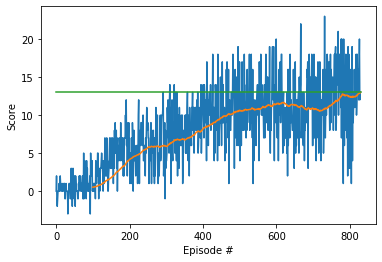

In [8]:
# plot the scores
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

ma_scores = movingaverage(scores, 100)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(ma_scores))+100, ma_scores)
plt.plot([0, len(scores)], [13, 13])
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig("scores.png")
plt.show()
    
    

In [9]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, 0)                   # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 6.0


When finished, you can close the environment.

In [10]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```